In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import statistics
import pickle

In [2]:
bootstrap_set = pd.read_csv("traffic.csv")

In [8]:
bootstrap_set['to_score'] = 0

In [10]:
data_location = input("Enter file location: ")

Enter file location: traffic.csv


In [11]:
current_set = pd.read_csv(data_location)

In [12]:
raw_cols = current_set.columns

In [13]:
current_set['to_score'] = 1

In [14]:
driverset = pd.concat([bootstrap_set,current_set]).drop_duplicates(subset=raw_cols, keep="last")

In [28]:
driverset['date_time'] = pd.to_datetime(driverset['date_time'])
driverset['year'] = pd.DatetimeIndex(driverset['date_time']).year
driverset['month'] = pd.DatetimeIndex(driverset['date_time']).month
driverset['hod'] = pd.DatetimeIndex(driverset['date_time']).hour
driverset['dow'] = pd.DatetimeIndex(driverset['date_time']).dayofweek
driverset = driverset.sort_values('date_time')

In [29]:
#create cutoffs based on distribution
def weather_categorizer(weather_df):
    if (weather_df['weather_type']!='Clouds') and (weather_df['weather_type']!='Clear'):
        return 'other'
    return weather_df['weather_type']

def rain_categorizer(rain_df):
    if (rain_df['rain_mm'] == 0):
        return "Level 0"
    return "Level 1"
    
def snow_categorizer(snow_df):
    if (snow_df['snow_mm'] == 0):
        return "Level 0"
    return "Level 1"

In [30]:
driverset['rain_level'] = driverset.apply(rain_categorizer, axis=1)
driverset['snow_level'] = driverset.apply(snow_categorizer, axis=1)
driverset['weather_type'] = driverset.apply(weather_categorizer, axis=1)

In [39]:
categorical_cols_imbalanced = ['rain_level','snow_level','holiday'] 
categorical_cols_other = ['weather_type']
ordinal_cols = ['hod','dow']

In [40]:
for col in categorical_cols_imbalanced + categorical_cols_other + ordinal_cols:
    driverset[col+'_vol_avg_to_date'] = driverset.groupby(col,as_index=False)['traffic_volume'].shift().expanding().mean().reset_index(level=0, drop=True)
    driverset[col+'_vol_max_to_date'] = driverset.groupby(col,as_index=False)['traffic_volume'].shift().expanding().max().reset_index(level=0, drop=True)
    driverset[col+'_vol_min_to_date'] = driverset.groupby(col,as_index=False)['traffic_volume'].shift().expanding().min().reset_index(level=0, drop=True)


In [32]:
order_window_dict = {'hod': [7],'dow':[24]}
def ordinal_aggregator(df, order_window_dict):
    for order, windows in order_window_dict.items():
        for window in windows:
            if order == 'hod':
                # volume at last hod
                df['vol_lag_'+str(order)+'h'] = df['traffic_volume'].shift(24)
                # min over last 7 hod
                df['vol_min_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).min().reset_index(level=0, drop=True)
                # max over last 7 hod
                df['vol_max_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).max().reset_index(level=0, drop=True)
                # avg over last 7 hod
                df['vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
                # std over last 7 hod
                df['vol_std_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).std().reset_index(level=0, drop=True)
            #if order == 'dow':
                # avg over 24 dowh previous to current
                #df['vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby(order,as_index=False)['traffic_volume'].shift(window).rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
    return df
    
def category_aggregator(df, category, order_window_dict):
    for order, windows in order_window_dict.items():
        for window in windows:
            if order == 'hod':
                # volume at last hod
                df[category+'_vol_lag_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift(24)
                # min over last 7 hod
                df[category+'_vol_min_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).min().reset_index(level=0, drop=True)
                # max over last 7 hod
                df[category+'_vol_max_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).max().reset_index(level=0, drop=True)
                # avg over last 7 hod
                df[category+'_vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
                # std over last 7 hod
                df[category+'_vol_std_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift().rolling(window=window,min_periods=1).std().reset_index(level=0, drop=True)
            #if order == 'dow':
                # avg over 24 dowh previous to current
                #df[category+'_vol_avg_l'+str(window)+'_'+str(order)+'h'] = df.groupby([order,category],as_index=False)['traffic_volume'].shift(window).rolling(window=window,min_periods=1).mean().reset_index(level=0, drop=True)
    return df

def imbalanced_category_aggregator(df, category):
    # volume at last hour
    df[category+'_vol_lag_h'] = df.groupby(category)['traffic_volume'].shift()
    # avg over last 24h
    #df[category+'_vol_l24h'] = df.groupby(category)['traffic_volume'].shift().rolling(window=24,min_periods=1).mean().reset_index(level=0, drop=True)
    # avg over last 24h previous to current
    #df[category+'_vol_l1d'] = df.groupby(category)['traffic_volume'].shift(24).rolling(window=24,min_periods=1).mean().reset_index(level=0, drop=True)
    return df

def add_agg_features(df):
    # volume at last hour
    df['vol_lag_hr'] = df['traffic_volume'].shift()
    # avg over last 24h
    #df['vol_avg_l24h'] = df['traffic_volume'].shift().rolling(window=24,min_periods=1).mean().reset_index(level=0, drop=True)
    # volume at last hod, dow
    df['vol_lag_hod_dow'] = df['traffic_volume'].shift(168)
    # min over last 4 hod, dow
    df['vol_min_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).min().reset_index(level=0, drop=True)
    # max over last 4 hod, dow
    df['vol_max_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).max().reset_index(level=0, drop=True)
    # avg over last 4 hod, dow
    df['vol_avg_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).mean().reset_index(level=0, drop=True)
    # std over last 4 hod, dow
    df['vol_std_l4_hod_dow'] = df.groupby(['hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).std().reset_index(level=0, drop=True)
    return df

def add_category_agg_features(df, category):
    # volume at last hour
    df[category+'_vol_lag_hr'] = df.groupby(category)['traffic_volume'].shift()
    # volume at last hod, dow
    df[category+'_vol_lag_hod_dow'] = df.groupby(category)['traffic_volume'].shift(168)
    # min over last 4 hod, dow
    df[category+'_vol_min_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).min().reset_index(level=0, drop=True)
    # max over last 4 hod, dow
    df[category+'_vol_max_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).max().reset_index(level=0, drop=True)
    # avg over last 4 hod, dow
    df[category+'_vol_avg_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).mean().reset_index(level=0, drop=True)
    # std over last 4 hod, dow
    df[category+'_vol_std_l4_hod_dow'] = df.groupby([category,'hod','dow'],as_index=False)['traffic_volume'].shift().rolling(window=4,min_periods=1).std().reset_index(level=0, drop=True)
    return df
    

In [33]:
driverset = ordinal_aggregator(driverset, order_window_dict)
driverset = add_agg_features(driverset)
for category in categorical_cols_imbalanced:
    driverset = imbalanced_category_aggregator(driverset, category)
for category in categorical_cols_other:
    driverset = category_aggregator(driverset, category, order_window_dict)
    driverset = add_category_agg_features(driverset, category)

In [34]:
features = ['holiday_vol_lag_h'
                     ,'vol_lag_hr'
                     ,'weather_type_vol_lag_hodh'
                     ,'vol_std_l4_hod_dow'
                     ,'snow_level_vol_lag_h'
                     ,'rain_level_vol_lag_h'
                     ,'weather_type_vol_max_to_date'
                     ,'dow_vol_avg_to_date'
                     ,'temp_F'
                     ,'cloud_cover_%'
                     ]

In [35]:
model_location = 'traffic_volume_model.sav'
gbtr = pickle.load(open(model_location, 'rb'))

In [41]:
set_to_score = driverset[driverset['to_score']==1].dropna()

In [42]:
y_pred = gbtr.predict(set_to_score[features])

In [43]:
print('RMSE:', np.sqrt(mean_squared_error(set_to_score['traffic_volume'], y_pred)), 'trips.')
print('R2:', r2_score(set_to_score['traffic_volume'], y_pred))

RMSE: 742.0423652791649 trips.
R2: 0.8606419758322389


In [44]:
X_eval = set_to_score
X_eval['y_pred'] = y_pred
X_eval = X_eval.sort_values('date_time')

/home/kidconnect/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(array([735964., 736024., 736085., 736146., 736208., 736269., 736330.]),
 <a list of 7 Text xticklabel objects>)

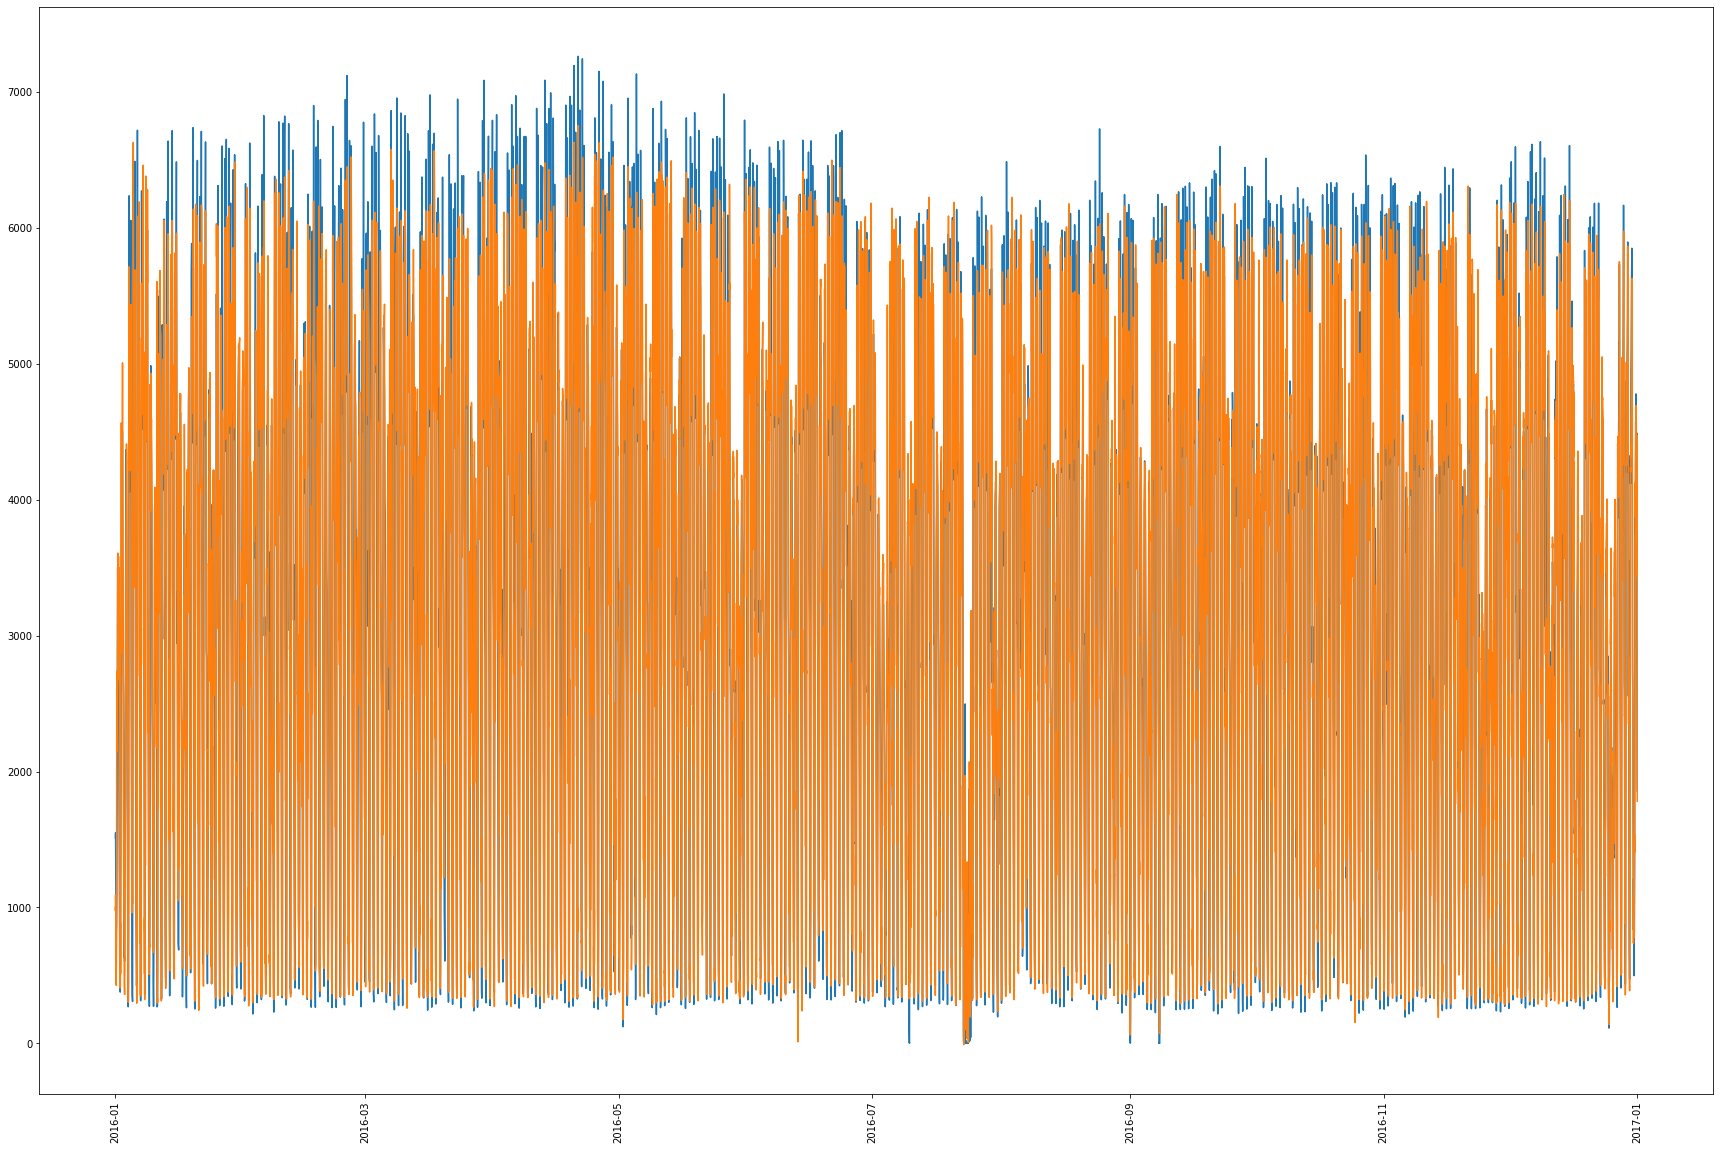

In [45]:
X_eval['year'] = pd.DatetimeIndex(X_eval['date_time']).year
fig = plt.figure(figsize=(30,20))
X_eval_sample = X_eval[X_eval['year']==2016]
plt.plot(X_eval_sample['date_time'], X_eval_sample[['traffic_volume','y_pred']])
plt.xticks(rotation='vertical')